In [12]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date,datetime,timedelta

from backtesting import Backtest, Strategy
from backtesting.test import SMA

In [33]:
def stock_data_all(ticker):

    start_date1 = date.today()-timedelta(days=500)

    start_date = start_date1.strftime("%Y-%m-%d")

    # Request data:
    data = yf.download(ticker,
                        interval="1h",
                        start = start_date)
    
    return data
data1 = stock_data_all('SPY')

[*********************100%***********************]  1 of 1 completed


In [34]:
data = data1[['Open','High','Low','Adj Close','Volume']]
data = data.rename(columns={'Adj Close': 'Close'}, inplace=False)
data.head()

,Open,High,Low,Close,Volume
2020-02-24 09:30:00-05:00,323.140015,325.850006,322.869995,324.330994,35670773
2020-02-24 10:30:00-05:00,324.329987,324.920013,323.609985,324.299988,14751985
2020-02-24 11:30:00-05:00,324.295013,324.540009,322.339996,322.614990,16279707
2020-02-24 12:30:00-05:00,322.609985,323.440002,321.239990,322.559998,16969846
2020-02-24 13:30:00-05:00,322.570007,323.769989,322.070007,323.609985,14873917


In [35]:
def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


close = data.Close.values
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
sma100 = SMA(data.Close, 100)
upper, lower = BBANDS(data, 20, 2)

# Design matrix / independent features:

# Price-derived features
data['X_SMA10'] = (close - sma10) / close
data['X_SMA20'] = (close - sma20) / close
data['X_SMA50'] = (close - sma50) / close
data['X_SMA100'] = (close - sma100) / close

data['X_DELTA_SMA10'] = (sma10 - sma20) / close
data['X_DELTA_SMA20'] = (sma20 - sma50) / close
data['X_DELTA_SMA50'] = (sma50 - sma100) / close

# Indicator features
data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close
data['X_BB_width'] = (upper - lower) / close
data['X_Sentiment'] = ~data.index.to_series().between('2017-09-27', '2017-12-14')

# Some datetime features for good measure
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

data = data.dropna().astype(float)

In [36]:
def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values


def get_y(data):
    """Return dependent variable y"""
    y = data.Close.pct_change(48).shift(-48)  # Returns after roughly two days
    y[y.between(-.004, .004)] = 0             # Devalue returns smaller than 0.4%
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y

Classification accuracy:  0.5490716180371353


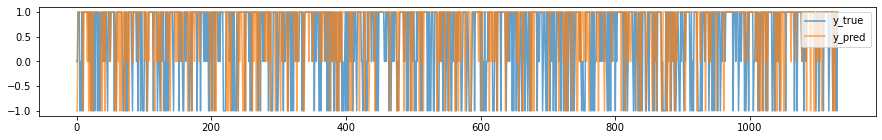

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X, y = get_clean_Xy(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

clf = KNeighborsClassifier(7)  # Model the output based on 7 "nearest" examples
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

_ = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred}).plot(figsize=(15, 2), alpha=.7)
print('Classification accuracy: ', np.mean(y_test == y_pred))

In [38]:
%%time

from backtesting import Backtest, Strategy

N_TRAIN = 400


class MLTrainOnceStrategy(Strategy):
    price_delta = .004  # 0.4%

    def init(self):        
        # Init our model, a kNN classifier
        self.clf = KNeighborsClassifier(7)

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')

    def next(self):
        # Skip the training, in-sample data
        if len(self.data) < N_TRAIN:
            return

        # Proceed only with out-of-sample data. Prepare some variables
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]

        # Forecast the next movement
        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.2, tp=lower, sl=upper)

        # Additionally, set aggressive stop-loss on trades that have been open 
        # for more than two days
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)


bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
bt.run()

Wall time: 2.5 s


Start                     2020-03-13 10:30...
End                       2021-07-06 15:30...
Duration                    480 days 05:00:00
Exposure Time [%]                      82.684
Equity Final [$]                      7406.85
Equity Peak [$]                       11333.6
Return [%]                           -25.9315
Buy & Hold Return [%]                 71.5038
Return (Ann.) [%]                    -20.4302
Volatility (Ann.) [%]                 36.1421
Sharpe Ratio                                0
Sortino Ratio                               0
Calmar Ratio                                0
Max. Drawdown [%]                    -47.3972
Avg. Drawdown [%]                    -7.05144
Max. Drawdown Duration      307 days 01:00:00
Avg. Drawdown Duration       33 days 01:00:00
# Trades                                  717
Win Rate [%]                          47.2803
Best Trade [%]                        1.56495
Worst Trade [%]                      -2.05796
Avg. Trade [%]                    

In [39]:
bt.plot()

<ipython-input-39-5ae8d19b00ab>:1: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  bt.plot()


In [40]:
%%time

class MLWalkForwardStrategy(MLTrainOnceStrategy):
    def next(self):
        # Skip the cold start period with too few values available
        if len(self.data) < N_TRAIN:
            return

        # Re-train the model only every 20 iterations.
        # Since 20 << N_TRAIN, we don't lose much in terms of
        # "recent training examples", but the speed-up is significant!
        if len(self.data) % 20:
            return super().next()

        # Retrain on last N_TRAIN values
        df = self.data.df[-N_TRAIN:]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Now that the model is fitted, 
        # proceed the same as in MLTrainOnceStrategy
        super().next()


bt = Backtest(data, MLWalkForwardStrategy, commission=.0002, margin=.05)
bt.run()

Wall time: 3.12 s


Start                     2020-03-13 10:30...
End                       2021-07-06 15:30...
Duration                    480 days 05:00:00
Exposure Time [%]                     80.4329
Equity Final [$]                      4467.69
Equity Peak [$]                       10821.9
Return [%]                           -55.3231
Buy & Hold Return [%]                 71.5038
Return (Ann.) [%]                    -45.8501
Volatility (Ann.) [%]                 23.8806
Sharpe Ratio                                0
Sortino Ratio                               0
Calmar Ratio                                0
Max. Drawdown [%]                    -61.6067
Avg. Drawdown [%]                     -12.272
Max. Drawdown Duration      307 days 01:00:00
Avg. Drawdown Duration       49 days 16:00:00
# Trades                                  813
Win Rate [%]                          47.6015
Best Trade [%]                         1.1671
Worst Trade [%]                      -2.05796
Avg. Trade [%]                    

In [41]:
bt.plot()

<ipython-input-41-5ae8d19b00ab>:1: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  bt.plot()
